# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.mean()

real_age    31.201159
dtype: float64

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


[Text(0.5, 0, 'Возраст')]

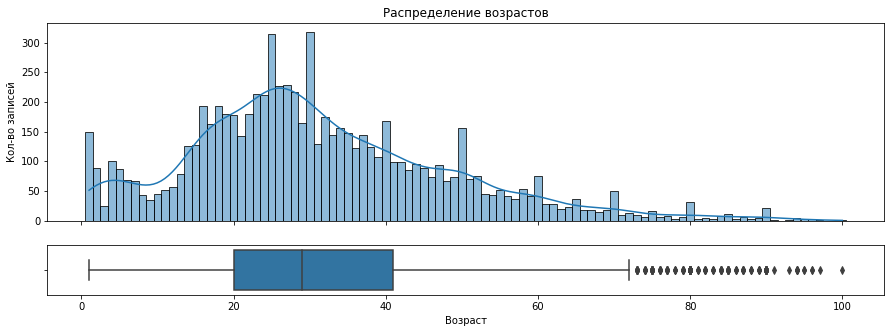

In [6]:
#строю гистограмму возрастов:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                      figsize=(15, 5),
                                      sharex=True,
                                      gridspec_kw=dict(height_ratios=[4,1]))

sns.histplot(data=labels,
             x='real_age',
             discrete=True,
             kde=True,
             ax=axs_hist)\
.set(title='Распределение возрастов', ylabel='Кол-во записей')

sns.boxplot(data=labels, x='real_age', ax=axs_box)\
.set(xlabel='Возраст')

Возраст: 4


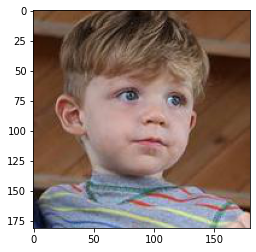

Возраст: 1


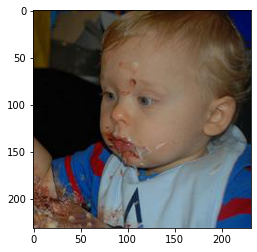

Возраст: 1


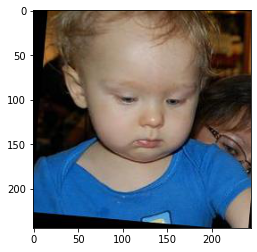

Возраст: 2


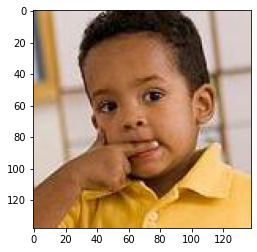

Возраст: 2


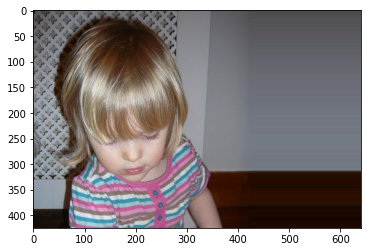

In [7]:
#смотрю на фото людей младше 5 лет
kids = labels[labels['real_age'] < 5]

for _, row in kids.sample(5, random_state = 10).iterrows():
    print('Возраст:', row['real_age'])
    image = Image.open('/datasets/faces/final_files/' +
                      row['file_name'])
    plt.imshow(image)
    plt.show()

Возраст: 37


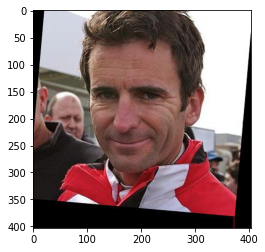

Возраст: 30


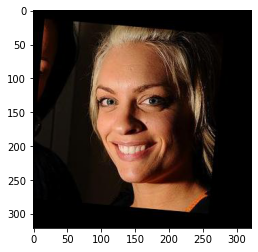

Возраст: 27


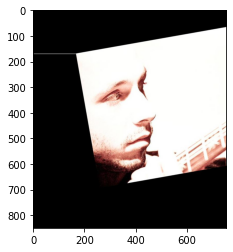

Возраст: 53


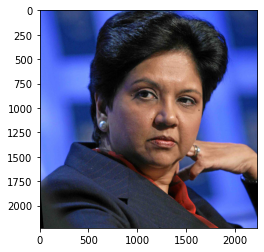

Возраст: 27


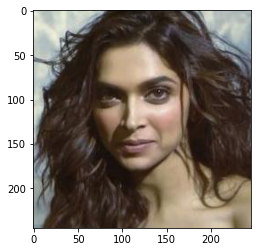

In [8]:
#смотрю на фото взрослых
adults = labels.query('18 <= real_age <= 55')

for _, row in adults.sample(5, random_state = 25).iterrows():
    print('Возраст:', row['real_age'])
    image = Image.open('/datasets/faces/final_files/' +
                      row['file_name'])
    plt.imshow(image)
    plt.show()

Возраст: 76


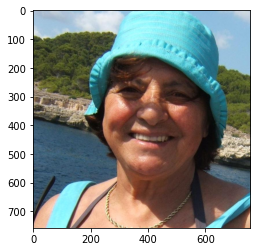

Возраст: 76


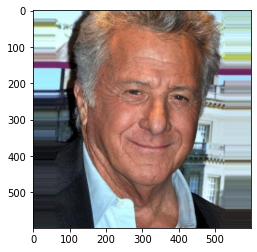

Возраст: 80


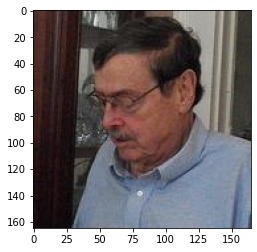

Возраст: 83


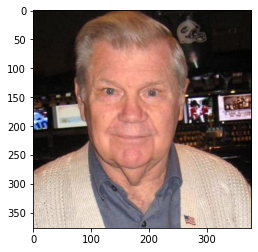

Возраст: 87


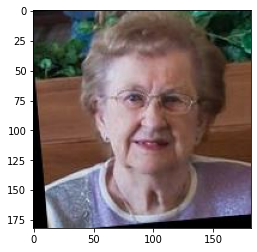

In [12]:
#смотрю фото людей старше 75
grays = labels[labels['real_age'] > 75]

for _, row in grays.sample(5, random_state = 35).iterrows():
    print('Возраст:', row['real_age'])
    image = Image.open('/datasets/faces/final_files/' +
                      row['file_name'])
    plt.imshow(image)
    plt.show()

### Вывод:

Есть набор фото из 7591 шт. + данные по возрасту человека на фото. Средний возраст — 31, медианный — 29, диапазон возрастов - от 1 года до 100 лет, больше всего людей 25 и 30 лет. 
Среди случайно отобранных фото не нашла неверно размеченных - общая ориентация фотографий примерно одинакова, в некоторых фото их уже повернули, чтобы выровнять положение лица, значит, их необязательно поворачивать, а начальный размер изображений отличается в силу того, что визуально заметно различное качество фото, где-то есть черные рамки. В итоге, размер изображений мы приведем к единому перед обучением модели
В целом данных достаточно

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       rescale=1./255)

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >

Train for 356 steps, validate for 119 steps

Epoch 1/20

2023-09-07 07:11:44.009218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-09-07 07:11:44.446841: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7

356/356 - 53s - loss: 198.0758 - mae: 10.6963 - val_loss: 428.6428 - val_mae: 15.6646

Epoch 2/20

356/356 - 42s - loss: 135.4305 - mae: 8.8948 - val_loss: 295.6423 - val_mae: 12.9537

Epoch 3/20

356/356 - 42s - loss: 109.6145 - mae: 7.9706 - val_loss: 187.4434 - val_mae: 10.0835

Epoch 4/20

356/356 - 42s - loss: 92.0078 - mae: 7.3085 - val_loss: 102.7185 - val_mae: 7.7103

Epoch 5/20

356/356 - 42s - loss: 78.9733 - mae: 6.8243 - val_loss: 113.2989 - val_mae: 7.9068

Epoch 6/20

356/356 - 42s - loss: 65.1705 - mae: 6.1724 - val_loss: 148.1329 - val_mae: 9.2703

Epoch 7/20

356/356 - 42s - loss: 55.2917 - mae: 5.7131 - val_loss: 97.5194 - val_mae: 7.5382

Epoch 8/20

356/356 - 42s - loss: 47.8320 - mae: 5.3307 - val_loss: 89.9770 - val_mae: 7.2014

Epoch 9/20

356/356 - 43s - loss: 46.3336 - mae: 5.2736 - val_loss: 94.7128 - val_mae: 7.4140

Epoch 10/20

356/356 - 42s - loss: 36.7906 - mae: 4.6707 - val_loss: 97.1364 - val_mae: 7.6316

Epoch 11/20

356/356 - 42s - loss: 30.6527 - mae: 4.2841 - val_loss: 81.0076 - val_mae: 6.5729

Epoch 12/20

356/356 - 42s - loss: 26.3201 - mae: 3.9099 - val_loss: 110.8210 - val_mae: 7.7825

Epoch 13/20

356/356 - 42s - loss: 26.2445 - mae: 3.9507 - val_loss: 102.0521 - val_mae: 7.5435

Epoch 14/20

356/356 - 43s - loss: 23.2356 - mae: 3.6970 - val_loss: 106.5797 - val_mae: 7.6568

Epoch 15/20

356/356 - 42s - loss: 22.9158 - mae: 3.7226 - val_loss: 93.0067 - val_mae: 7.2398

Epoch 16/20

356/356 - 42s - loss: 22.1401 - mae: 3.6011 - val_loss: 102.6020 - val_mae: 7.7241

Epoch 17/20

356/356 - 43s - loss: 23.8339 - mae: 3.7532 - val_loss: 117.1394 - val_mae: 8.4825

Epoch 18/20

356/356 - 43s - loss: 20.6022 - mae: 3.4913 - val_loss: 78.3117 - val_mae: 6.5027

Epoch 19/20

356/356 - 42s - loss: 17.5329 - mae: 3.2453 - val_loss: 81.6213 - val_mae: 6.7300

Epoch 20/20

356/356 - 44s - loss: 15.3322 - mae: 3.0203 - val_loss: 95.1332 - val_mae: 7.6186

WARNING:tensorflow:sample_weight modes were coerced from

  ...

    to  

  ['...']

119/119 - 10s - loss: 95.1332 - mae: 7.6186

Test MAE: 7.6186

# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Построенная модель по фото определяет возраст с ошибкой примерно 7 лет.

Если использовать эту модель, то ее достаточно для решения первой задачи - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы. И лучше, если покупателей разбивать на группы, например, с шагом 10.

Но для решения второй задачи - решение о продаже алкоголя - качества модели недостаточно. Если человеку 24 года, модель может определить его как 17-летнего и "запретить" продажу алкоголя. И тогда магазин лишится прибыли. Поэтому тут в спорных случаях можно подключить распознавание паспорта / водительского удостоверения.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы